https://www.kaggle.com/fournierp/captcha-version-2-images

In [192]:
from google.colab import drive
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
import cv2
import os
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder

# Loading Dataset

In [4]:
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
%cd /content/drive/My Drive/Colab Notebooks/Machine Learning Projects/(Kaggle) Captcha Slover/Dataset

/content/drive/My Drive/Colab Notebooks/Machine Learning Projects/(Kaggle) Captcha Slover/Dataset


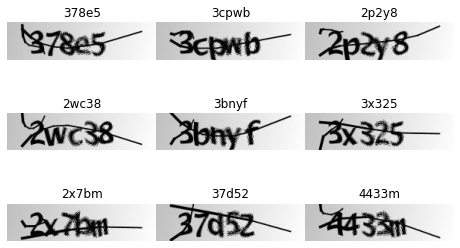

In [6]:
data_path = 'samples'
images = os.listdir(data_path)
sample_images = images[-9:]
fig, ax = plt.subplots(3, 3, figsize=(8, 5))
fig.subplots_adjust(wspace=0, hspace=0)
for i in range(9):
  img = cv2.imread(str(data_path + '/' + sample_images[i]))
  ax[i//3, i%3].imshow(img)
  ax[i//3, i%3].axis('off')
  ax[i//3, i%3].set_title(sample_images[i].split('.')[0])

# Image Preprocessing

In this section we are going preprocess a sample with opencv, remove the background noise line, let's take a look at the steps:

[**Simple Thresholding**](https://docs.opencv.org/4.x/d7/d4d/tutorial_py_thresholding.html)

* If the pixel value is smaller than the threshold, it is set to 0, otherwise it is set to a maximum value.

**Median Blur**

* 


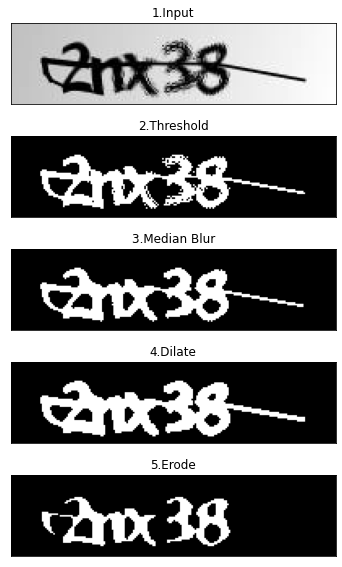

In [7]:
image_number = 1050
image = cv2.imread(data_path + '/' + images[image_number], cv2.IMREAD_GRAYSCALE)

ret, threshold = cv2.threshold(image, 127, 255, cv2.THRESH_BINARY_INV)

blur = cv2.medianBlur(threshold, 3)

kernel = np.ones([2, 2], np.uint8)
dilate = cv2.dilate(blur, kernel, iterations=1)

kernel = np.ones([5, 1], np.uint8)
erode = cv2.erode(dilate, kernel, iterations=1)

plot = [image, threshold, blur, dilate, erode]
title = ['1.Input', '2.Threshold', '3.Median Blur', '4.Dilate', '5.Erode']

fig, ax = plt.subplots(5, 1, figsize=(15, 8))
fig.tight_layout()

for i, j, k in zip(range(len(plot)), plot, title):
  ax[i].imshow(j, cmap='gray')
  ax[i].set_title(k)
  ax[i].set_xticks([])
  ax[i].set_yticks([])

Since each 

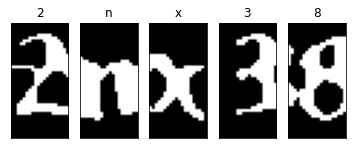

In [8]:
split = [erode[10:50,30:50],erode[10:50,50:70],
                 erode[10:50,70:90],erode[10:50,90:110],erode[10:50,110:130]]

label = images[image_number].split('.')[0]

fig, ax = plt.subplots(1, 5)
for i, j in zip(range(len(label)), label):
  ax[i].imshow(split[i], cmap='gray')
  ax[i].set_title(j)
  ax[i].set_xticks([])
  ax[i].set_yticks([])

Preprocess all image with previous steps and split, convert each character as numpy arrays.

Individual image of each character and label are put into numpy array X and y

In [297]:
X = []
y = []
for i in images:
  #print('Preprocessing: ' + i)

  image = cv2.imread(data_path + '/' + i, cv2.IMREAD_GRAYSCALE)

  ret, image = cv2.threshold(image, 127, 255, cv2.THRESH_BINARY_INV)
  image = cv2.medianBlur(image, 3)

  kernel = np.ones([2, 2], np.uint8)
  image = cv2.dilate(image, kernel, iterations=1)

  kernel = np.ones([5, 1], np.uint8)
  image = cv2.erode(image, kernel, iterations=1)

  split=[image[10:50,30:50],image[10:50,50:70],
         image[10:50,70:90],image[10:50,90:110],
         image[10:50,110:130]]

  for j in range(len(split)):
    X.append(keras.preprocessing.image.img_to_array(split[j]))
    y.append(i[j])

X = np.array(X)
y = np.array(y)

Let's take a look at a subset of splitted characters

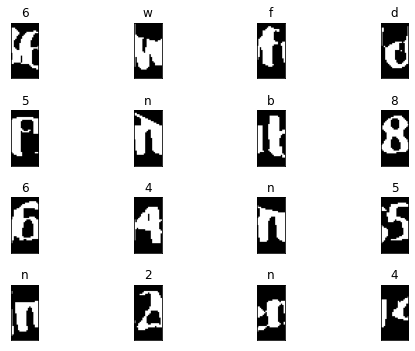

In [324]:
random = np.random.choice(len(X), size=16, replace=False)
fig, ax = plt.subplots(4, 4, figsize=(7, 5))
fig.tight_layout()
for i, j in zip(random, range(len(random))):
  ax[j//4, j%4].imshow(X[i][:,:,0], cmap='gray')
  ax[j//4, j%4].set_title(y[i])
  ax[j//4, j%4].set_xticks([])
  ax[j//4, j%4].set_yticks([])

Label encoding and one hot encoding

In [290]:
label_encoder = LabelEncoder()
y_label_encoded = label_encoder.fit_transform(y)

one_hot_encoder = OneHotEncoder(sparse=False)
y_one_hot_encoded = one_hot_encoder.fit_transform(y_label_encoded.reshape(-1, 1))

X_train, X_test, y_train, y_test = train_test_split(X, y_one_hot_encoded, test_size=0.2, shuffle=True)

There are 19 distince characters in the whole dataset, meaning the model will output 19 class probablities

In [385]:
num_of_classes = y_one_hot_encoded.shape[1]
num_of_classes

19

In [322]:
label_encoded = {y_label_encoded[i] : y[i] for i in range(len(y))}
label_encoded

{0: '2',
 1: '3',
 2: '4',
 3: '5',
 4: '6',
 5: '7',
 6: '8',
 7: 'b',
 8: 'c',
 9: 'd',
 10: 'e',
 11: 'f',
 12: 'g',
 13: 'm',
 14: 'n',
 15: 'p',
 16: 'w',
 17: 'x',
 18: 'y'}

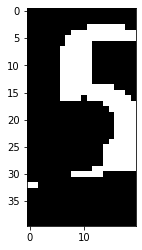

In [310]:
plt.imshow(X_train[40][:,:,0], cmap='gray')

Inverse transform from one hot encoded label to actual label

In [309]:
label_encoder.inverse_transform([np.argmax(y_train[40, :])])

array(['5'], dtype='<U1')

Heigh and width of each individual character

In [318]:
height = X.shape[1]
width = X.shape[2]
print(height, width)

40 20


# Building the CNN Model

In [412]:
model = keras.Sequential([
    keras.layers.Conv2D(filters=16, kernel_size=(3, 3), padding='same', 
                        activation='relu', input_shape=(height, width, 1)),
    keras.layers.MaxPooling2D(2),
    keras.layers.Conv2D(filters=32, kernel_size=(3, 3), activation='relu',
                        padding='same'),
    keras.layers.Conv2D(filters=32, kernel_size=(3, 3), activation='relu',
                        padding='same'),
    keras.layers.MaxPooling2D(2),
    keras.layers.Conv2D(filters=64, kernel_size=(3, 3), activation='relu',
                        padding='same'),
    keras.layers.Conv2D(filters=64, kernel_size=(3, 3), activation='relu',
                        padding='same'),
    keras.layers.MaxPooling2D(2),
    keras.layers.Flatten(),
    keras.layers.Dense(1500, activation='relu'),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(num_of_classes, activation='softmax')
])

In [405]:
model.summary()

Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_80 (Conv2D)          (None, 40, 20, 16)        160       
                                                                 
 max_pooling2d_42 (MaxPoolin  (None, 20, 10, 16)       0         
 g2D)                                                            
                                                                 
 conv2d_81 (Conv2D)          (None, 20, 10, 32)        4640      
                                                                 
 conv2d_82 (Conv2D)          (None, 20, 10, 32)        9248      
                                                                 
 max_pooling2d_43 (MaxPoolin  (None, 10, 5, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_83 (Conv2D)          (None, 10, 5, 64)       

In [415]:
optimizer = keras.optimizers.Adam()
loss = 'categorical_crossentropy'
model.compile(loss=loss, optimizer=optimizer, metrics=['accuracy'])

In [419]:
tf.keras.callbacks.TensorBoard(
    log_dir='logs', histogram_freq=0, write_graph=True,
    write_images=True, write_steps_per_second=True, update_freq='epoch',
    profile_batch=0, embeddings_freq=0, embeddings_metadata=None)

In [ ]:
batch_size = 200
epochs = 300
history = model.fit(X_train, y_train, batch_size=batch_size,
                    epochs=epochs, validation_data=(X_test, y_test))

Epoch 1/300
22/22 [==============================] - 6s 285ms/step - loss: 0.0981 - accuracy: 0.9685 - val_loss: 0.6626 - val_accuracy: 0.8598
Epoch 2/300
22/22 [==============================] - 6s 284ms/step - loss: 0.0858 - accuracy: 0.9717 - val_loss: 0.6784 - val_accuracy: 0.8682
Epoch 3/300
22/22 [==============================] - 6s 281ms/step - loss: 0.0827 - accuracy: 0.9734 - val_loss: 0.6238 - val_accuracy: 0.8598
Epoch 4/300
22/22 [==============================] - 6s 283ms/step - loss: 0.0638 - accuracy: 0.9790 - val_loss: 0.6407 - val_accuracy: 0.8654
Epoch 5/300
22/22 [==============================] - 6s 283ms/step - loss: 0.0630 - accuracy: 0.9783 - val_loss: 0.6550 - val_accuracy: 0.8664
Epoch 6/300
22/22 [==============================] - 6s 283ms/step - loss: 0.0539 - accuracy: 0.9801 - val_loss: 0.7399 - val_accuracy: 0.8654
Epoch 7/300
22/22 [==============================] - 6s 283ms/step - loss: 0.0452 - accuracy: 0.9862 - val_loss: 0.7909 - val_accuracy: 0.8505

https://www.kaggle.com/ritabratanag/captcha-95-accuracy/notebook